# Student name: Pat O'Dowd

# Student ID: 8273375

In [31]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import (ColumnTransformer, TransformedTargetRegressor)
from sklearn.base import (BaseEstimator, TransformerMixin)
from sklearn.preprocessing import (StandardScaler, RobustScaler, OneHotEncoder, FunctionTransformer,MinMaxScaler)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import set_config
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

# imports necessary for dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn import svm,random_projection
from sklearn.neighbors import KNeighborsClassifier

# regression algorithms
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

# metrics for evaluating regression models
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [32]:
df = pd.read_csv("./insurance.csv")
df.head()
set_config(transform_output='pandas')

In [33]:
df.describe()

age          bmi     children  insurance_cost
count  1338.000000  1338.000000  1338.000000     1338.000000
mean     39.207025    30.663397     1.094918    13270.422265
std      14.049960     6.098187     1.205493    12110.011237
min      18.000000    15.960000     0.000000     1121.873900
25%      27.000000    26.296250     0.000000     4740.287150
50%      39.000000    30.400000     1.000000     9382.033000
75%      51.000000    34.693750     2.000000    16639.912515
max      64.000000    53.130000     5.000000    63770.428010

In [34]:
df['smoker'].value_counts()

smoker
no     1064
yes     274
Name: count, dtype: int64

In [35]:
df.head()

age  gender     bmi  children smoker     region  insurance_cost
0   18    male  33.770         1     no  southeast      1725.55230
1   18    male  34.100         0     no  southeast      1137.01100
2   18  female  26.315         0     no  northeast      2198.18985
3   18  female  38.665         2     no  northeast      3393.35635
4   18  female  35.625         0     no  northeast      2211.13075

In [36]:
df.isna().sum()

age               0
gender            0
bmi               0
children          0
smoker            0
region            0
insurance_cost    0
dtype: int64

In [37]:
df[df['insurance_cost']> 35000]

age  gender     bmi  children smoker     region  insurance_cost
9      18  female  36.850         0    yes  southeast     36149.48350
38     18    male  38.170         0    yes  southeast     36307.79830
40     18  female  42.240         0    yes  southeast     38792.68560
87     19    male  36.955         0    yes  northwest     36219.40545
128    19  female  32.490         0    yes  northwest     36898.73308
...   ...     ...     ...       ...    ...        ...             ...
1300   63  female  32.200         2    yes  southwest     47305.30500
1317   64  female  31.300         2    yes  southwest     47291.05500
1319   64  female  33.800         1    yes  southwest     47928.03000
1325   64    male  33.880         0    yes  southeast     46889.26120
1336   64    male  36.960         2    yes  southeast     49577.66240

[133 rows x 7 columns]

<Axes: >

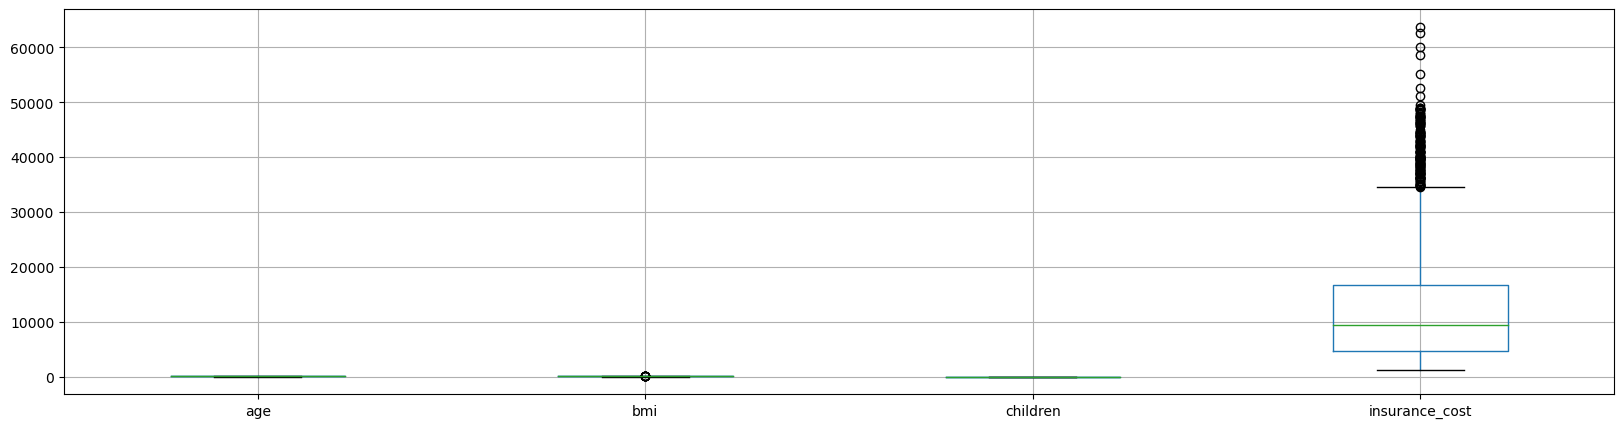

In [38]:
df.boxplot(figsize=(20,5))

In [39]:
# Creating a customer transformer class for bmi category instead of BMI
class bmi_category(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Map BMI to BMI Category underweight to obese
        X['bmi'] = np.where(X['bmi']<18.5,0.0,X['bmi'])
        X['bmi'] = np.where((X['bmi']>=18.5) & (X['bmi']<25),0.2,X['bmi'])
        X['bmi'] = np.where((X['bmi']>=25) & (X['bmi']<30),0.4,X['bmi'])
        X['bmi'] = np.where((X['bmi']>=30) & (X['bmi']<35),0.6,X['bmi'])
        X['bmi'] = np.where((X['bmi']>=35) & (X['bmi']<40),0.8,X['bmi'])
        X['bmi'] = np.where((X['bmi']>=40),1.0,X['bmi'])
        

        return X

class age_category(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Map Age to Age Group 
        X['age'] = np.where(X['age']<20,0.0,X['age'])
        X['age'] = np.where((X['age']>=20) & (X['age']<26),0.2,X['age'])
        X['age'] = np.where((X['age']>=26) & (X['age']<36),0.4,X['age'])
        X['age'] = np.where((X['age']>=36) & (X['age']<46),0.6,X['age'])
        X['age'] = np.where((X['age']>=46) & (X['age']<56),0.8,X['age'])
        X['age'] = np.where((X['age']>=56),1.0,X['age'])

        

        return X

def yes_no_to_binary(df):   
    return df.apply(lambda x: x.replace({'yes': 1, 'no': 0}))



In [40]:
df.head()

age  gender     bmi  children smoker     region  insurance_cost
0   18    male  33.770         1     no  southeast      1725.55230
1   18    male  34.100         0     no  southeast      1137.01100
2   18  female  26.315         0     no  northeast      2198.18985
3   18  female  38.665         2     no  northeast      3393.35635
4   18  female  35.625         0     no  northeast      2211.13075

In [41]:
y = df['insurance_cost']
X = df.drop('insurance_cost', axis=1)

In [42]:
X.head()

age  gender     bmi  children smoker     region
0   18    male  33.770         1     no  southeast
1   18    male  34.100         0     no  southeast
2   18  female  26.315         0     no  northeast
3   18  female  38.665         2     no  northeast
4   18  female  35.625         0     no  northeast

In [43]:
df[df.insurance_cost == 0]

Empty DataFrame
Columns: [age, gender, bmi, children, smoker, region, insurance_cost]
Index: []

In [44]:
df['insurance_cost'].hist(bins=50)
plt.show()

In [46]:
# Add in various transformers.

# Function transformer to convert yes/no values to binary

smoker_transformer = FunctionTransformer(func=yes_no_to_binary)

# One hot encoder
oneHotEncoder_pipeline = Pipeline(
    steps = [
        ("oneHotEncoder", OneHotEncoder(sparse_output=False)
        )
    ]
)
# Transformer to convery bmi to bmi category
bmi_transformer = Pipeline(
    steps = [
        ("bmi_transformer", bmi_category()),
    ]
)

# Transformer to convert age to age group. Decided not to use this as the metrics came out better leaving age as a value

age_transformer = Pipeline(
    steps = [
        ("age_transformer", age_category()),
    ]
)



outliers_and_zeros_pipeline = Pipeline(
    steps = [
        ("cubic_root_transform", FunctionTransformer(np.cbrt)),
        ("scaler", RobustScaler())
    ]
)


standard_scaler = Pipeline(
    steps = [
        ("scaler", StandardScaler())
    ]
)

minmax_scaler = Pipeline(
    steps = [
        ("scaler", MinMaxScaler())
    ]
)

preprocess_pipeline = ColumnTransformer(
    transformers = [
        ("oneHotEncoder", oneHotEncoder_pipeline, ['region','gender']),
        ('bmi_transformer',bmi_transformer, ['bmi']),
        ('smoker_transformer',smoker_transformer,['smoker']),
#        ('age_transformer',age_transformer, ['age']),
        ('minmax_scaler',minmax_scaler, ['age','children'])  
    ],
    remainder="passthrough" # note there are no remaining columns in this example
)

In [47]:
X_transformed = preprocess_pipeline.fit_transform(X);

In [48]:
X_transformed.head()

oneHotEncoder__region_northeast  oneHotEncoder__region_northwest  \
0                              0.0                              0.0   
1                              0.0                              0.0   
2                              1.0                              0.0   
3                              1.0                              0.0   
4                              1.0                              0.0   

   oneHotEncoder__region_southeast  oneHotEncoder__region_southwest  \
0                              1.0                              0.0   
1                              1.0                              0.0   
2                              0.0                              0.0   
3                              0.0                              0.0   
4                              0.0                              0.0   

   oneHotEncoder__gender_female  oneHotEncoder__gender_male  \
0                           0.0                         1.0   
1                           0.0                         1.0   
2                           1.0                         0.0   
3                           1.0                         0.0   
4                           1.0                         0.0   

   bmi_transformer__bmi  smoker_transformer__smoker  minmax_scaler__age  \
0                   0.6                           0                 0.0   
1                   0.6                           0                 0.0   
2                   0.4                           0                 0.0   
3                   0.8                           0                 0.0   
4                   0.8                           0                 0.0   

   minmax_scaler__children  
0                      0.2  
1                      0.0  
2                      0.0  
3                      0.4  
4                      0.0

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [50]:
X_transformed = preprocess_pipeline.fit_transform(X);

In [51]:
X_transformed.describe()

oneHotEncoder__region_northeast  oneHotEncoder__region_northwest  \
count                      1338.000000                      1338.000000   
mean                          0.242152                         0.242900   
std                           0.428546                         0.428995   
min                           0.000000                         0.000000   
25%                           0.000000                         0.000000   
50%                           0.000000                         0.000000   
75%                           0.000000                         0.000000   
max                           1.000000                         1.000000   

       oneHotEncoder__region_southeast  oneHotEncoder__region_southwest  \
count                      1338.000000                      1338.000000   
mean                          0.272048                         0.242900   
std                           0.445181                         0.428995   
min                           0.000000                         0.000000   
25%                           0.000000                         0.000000   
50%                           0.000000                         0.000000   
75%                           1.000000                         0.000000   
max                           1.000000                         1.000000   

       oneHotEncoder__gender_female  oneHotEncoder__gender_male  \
count                   1338.000000                 1338.000000   
mean                       0.494768                    0.505232   
std                        0.500160                    0.500160   
min                        0.000000                    0.000000   
25%                        0.000000                    0.000000   
50%                        0.000000                    1.000000   
75%                        1.000000                    1.000000   
max                        1.000000                    1.000000   

       bmi_transformer__bmi  smoker_transformer__smoker  minmax_scaler__age  \
count           1338.000000                 1338.000000         1338.000000   
mean               0.526906                    0.204783            0.461022   
std                0.236927                    0.403694            0.305434   
min                0.000000                    0.000000            0.000000   
25%                0.400000                    0.000000            0.195652   
50%                0.600000                    0.000000            0.456522   
75%                0.600000                    0.000000            0.717391   
max                1.000000                    1.000000            1.000000   

       minmax_scaler__children  
count              1338.000000  
mean                  0.218984  
std                   0.241099  
min                   0.000000  
25%                   0.000000  
50%                   0.200000  
75%                   0.400000  
max                   1.000000

In [52]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('ttr', TransformedTargetRegressor(
                           regressor=RandomForestRegressor(n_estimators=10),
                           func=np.log, 
                           inverse_func=np.exp)
                       )
                      ]
               )

In [53]:
N_FEATURES_OPTIONS = [4, 5, 7]
MAX_DEPTH_OPTIONS = [2, 4, 6, 8]
MAX_FEATURES = [1,2,3]
CRITERION=['squared_error', 'absolute_error', 'friedman_mse', 'poisson']

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'ttr__regressor__max_depth': MAX_DEPTH_OPTIONS,
        'ttr__regressor__max_features': MAX_FEATURES,
        'ttr__regressor__criterion': CRITERION
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'ttr__regressor__max_depth': MAX_DEPTH_OPTIONS,
        'ttr__regressor__max_features': MAX_FEATURES,
        'ttr__regressor__criterion': CRITERION
    } ,
    {
        'reduce_dim': [random_projection.GaussianRandomProjection(n_components=10)],
        'ttr__regressor__max_depth': MAX_DEPTH_OPTIONS,
        'ttr__regressor__max_features': MAX_FEATURES,
        'ttr__regressor__criterion': CRITERION
    }  

]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.853:
Best parameters:  {'reduce_dim': RFE(estimator=SVR(gamma='auto', kernel='linear'), n_features_to_select=5), 'reduce_dim__n_features_to_select': 5, 'ttr__regressor__criterion': 'absolute_error', 'ttr__regressor__max_depth': 8, 'ttr__regressor__max_features': 3}


In [54]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('ttr', TransformedTargetRegressor(
                           regressor=LinearRegression(),
                           func=np.log, 
                           inverse_func=np.exp)
                       )
                      ]
               )

In [55]:
N_FEATURES_OPTIONS = [4,5,7]
FIT_INTERCEPT_OPTIONS = [False, True]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'ttr__regressor__fit_intercept': FIT_INTERCEPT_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'ttr__regressor__fit_intercept': FIT_INTERCEPT_OPTIONS
    }  
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
LR_best_params = search.best_params_
LR_best_model = search.best_estimator_

Best CV score = 0.570:
Best parameters:  {'reduce_dim': RFE(estimator=LinearRegression(), n_features_to_select=7), 'reduce_dim__n_features_to_select': 7, 'ttr__regressor__fit_intercept': True}


In [56]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('ttr', TransformedTargetRegressor(
                           regressor=SVR(),
                           func=np.log, 
                           inverse_func=np.exp)
                       )
                      ]
               )

In [57]:
N_FEATURES_OPTIONS = [4, 7, 8]
KERNEL_OPTIONS = ['linear','poly','rbf']
EPSILON=[0.05,0.1,0.15,0.17]
C=[1,3,5,7]
param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'ttr__regressor__kernel': KERNEL_OPTIONS,
        'ttr__regressor__epsilon': EPSILON,
        'ttr__regressor__C': C
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'ttr__regressor__kernel': KERNEL_OPTIONS,
        'ttr__regressor__epsilon': EPSILON,
        'ttr__regressor__C': C

    }  
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
SV_best_params = search.best_params_
SV_best_model = search.best_estimator_

Best CV score = 0.844:
Best parameters:  {'reduce_dim': RFE(estimator=SVR(gamma='auto', kernel='linear'), n_features_to_select=7), 'reduce_dim__n_features_to_select': 7, 'ttr__regressor__C': 3, 'ttr__regressor__epsilon': 0.15, 'ttr__regressor__kernel': 'rbf'}


In [58]:
# model - a trained regression model

def evaluate_model(X_test, y_test, model):
    
    # compute prediction for the test set
    _predicted_values = model.predict(X_test)
        
    # compute metrics
    _mse = mean_squared_error(y_test, _predicted_values)
    _mae = mean_absolute_error(y_test, _predicted_values)
    _r2 = r2_score(y_test, _predicted_values)
            
    return _mse, _mae, _r2

In [59]:
RF_mse, RF_mae, RF_r2 = evaluate_model(X_test, y_test, RF_best_model)
LR_mse, LR_mae, LR_r2 = evaluate_model(X_test, y_test, LR_best_model)
SV_mse, SV_mae, SV_r2 = evaluate_model(X_test, y_test, SV_best_model)

In [60]:
print(RF_r2,LR_r2,SV_r2)

0.8048931791672711 0.5727019015590532 0.7911165177058848


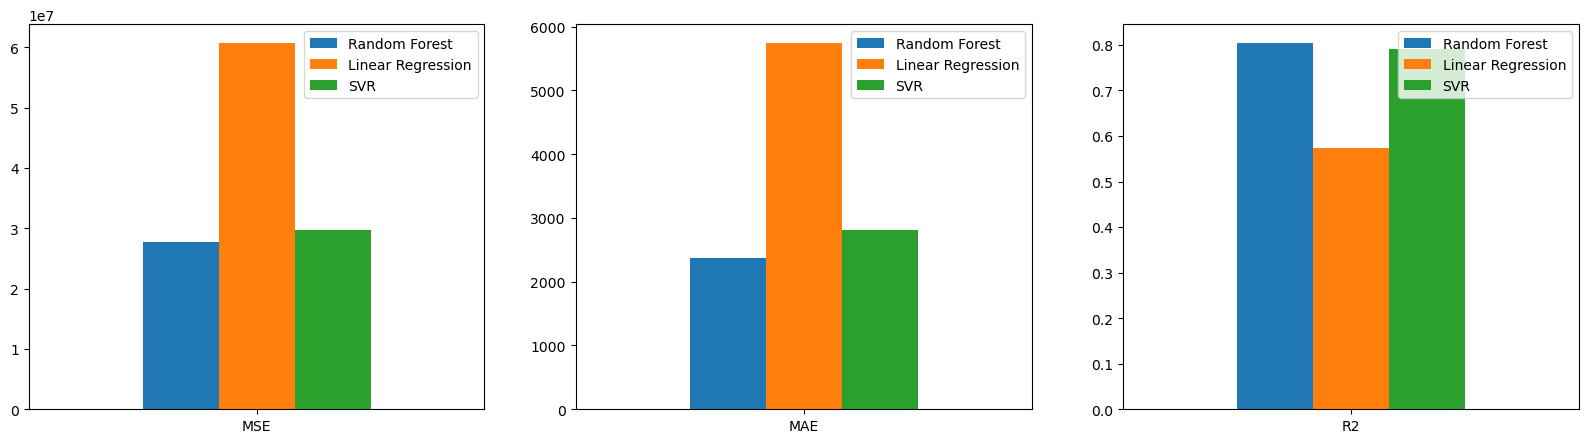

In [61]:
df_mse = pd.DataFrame({'Random Forest': RF_mse, 'Linear Regression': LR_mse, 'SVR': SV_mse}, index=['MSE'])
df_mae = pd.DataFrame({'Random Forest': RF_mae, 'Linear Regression': LR_mae, 'SVR': SV_mae}, index=['MAE'])
df_r2 = pd.DataFrame({'Random Forest': RF_r2, 'Linear Regression': LR_r2,'SVR': SV_r2}, index=['R2'])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

df_mse.plot.bar(rot=0, ax=axes[0])
df_mae.plot.bar(rot=0, ax=axes[1])
df_r2.plot.bar(rot=0, ax=axes[2])


plt.show()

In [62]:
# function to remove the string 'regresson__' from the names of the best parameters
def transform(dict, prefix):
    dict_prefix = {key:value for key,value in dict.items() if prefix in key}
    return {key.replace(prefix,''):value for key,value in dict_prefix.items()}

pipe = make_pipeline(preprocess_pipeline, 
                     RF_best_params.get('reduce_dim'),
                     RandomForestRegressor(n_estimators=10, **transform(RF_best_params, 'regresson__')))

final_model =pipe.fit(X, y)

## Sanity check on the regression model predictions
I took some data from the original data set and then added some synthetic data (identified with insurance_cost = 0). The results 
1. Show a good match between the predicted data and the actual data for the samples selected
2. Show expected correlation between predicted cost and factors like age, bmi and smoker as follows

    1. Higher BMI --> Higher cost
    2. Smoker Yes --> Higher cost
    3. Higher age --> Higher cost


In [63]:
df1 = pd.read_csv("./insurance_test.csv")
df1.tail()
y1 = df1['insurance_cost']
X1 = df1.drop('insurance_cost', axis=1)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
Best_mse, Best_mae, Best_r2 = evaluate_model(X1, y1, RF_best_model)
predicted_values = final_model.predict(X1)
df1['predicted'] = predicted_values
print(df1)

    age  gender     bmi  children smoker     region  insurance_cost     predicted
0    18    male  33.770         1     no  southeast      1725.55230   2329.180883
1    18  female  26.315         0     no  northeast      2198.18985   3295.575026
2    25    male  35.625         0     no  northwest      2534.39375   2565.928142
3    25  female  28.595         0     no  northeast      3213.62205   3049.835134
4    51  female  38.060         0    yes  southeast     44400.40640  44675.882048
5    64  female  26.885         0    yes  northwest     29330.98315  28993.361445
6    64    male  26.410         0     no  northeast     14394.55790  16076.770612
7    64    male  40.000         5    yes  southeast         0.00000  50303.520851
8    64    male  24.000         2    yes  southeast         0.00000  27090.460883
9    64  female  40.000         5    yes  southeast         0.00000  50303.520851
10   64  female  24.000         2    yes  southeast         0.00000  27090.460883
11   64    male 

In [65]:
filename = 'final_model.sav'
pickle.dump(final_model, open(filename, 'wb'))

# Summary of Results

Random Forest and Support Vector Regressor performed well whereas the linear model performed very poorly. Adjusting the number of features seemed to help particularly with the test set at the end. However it appeared that during training the maximum number of features was always selected based. I therefore restricted the maximum number of features to 7 or 8. Random forest and SVR gave similiar results on both the CV score and the test R1. In addition I created a final test set for sanity checking and the results indicate that prediction capabilities are reasonable against a sample of existing data. The Mean Absolute Error is in the range of 2000 to 3000 USD which I think is a good start given the insurance cost range is approx 1000USD to 64000USD. There are probably other partitions of the data set that may increase the accuracy of the predictions and also and increase in the number of records would also help. In addition for new data points the predictions are in line with what one would expect would impact insurance cost (namely age, smoking and obesity).